In [2]:
import torch
import numpy as np
from scipy.io import loadmat

from timedenoiser.models.cnn import ShallowCNN

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = loadmat('../../../datasets/Data_27012021_noisy/benchmark/bench1.mat')

# !cat ../../../datasets/Data_27012021_noisy/metadata.json

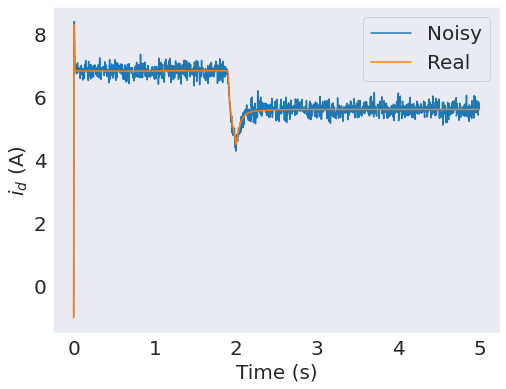

In [4]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(data['time'][0], data['noisy_current_d'][0], label='Noisy')
ax.plot(data['time'][0], data['current_d'][0], label='Real')
plt.ylabel(r'$i_d$ (A)', fontsize=20)
plt.xlabel('Time (s)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.show()

In [5]:
model = torch.load('../../weights/shallow_encdec/shallow_encdec_act_relu_stride_1_window_1000_inpQuants_noisy_current_d_outQuants_current_d_lr_0.1_batchSize_4192_epochs_100_loss_mse.pt')
model.eval()

DataParallel(
  (module): ShallowEncDec(
    (cnn1): Conv1d(1, 32, kernel_size=(10,), stride=(1,))
    (cnn2): Conv1d(32, 64, kernel_size=(7,), stride=(1,))
    (cnn3): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
    (cnn4): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
    (dcnn4): ConvTranspose1d(256, 128, kernel_size=(3,), stride=(1,))
    (dcnn3): ConvTranspose1d(128, 64, kernel_size=(5,), stride=(1,))
    (dcnn2): ConvTranspose1d(64, 32, kernel_size=(7,), stride=(1,))
    (dcnn1): ConvTranspose1d(32, 1, kernel_size=(10,), stride=(1,))
    (act): ReLU()
  )
)

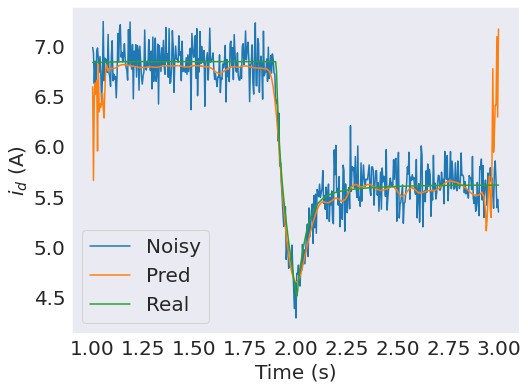

In [14]:
st = 1 * 250
w = 2  *250

x = np.stack([data['noisy_current_d'][0] / 30])
inp = torch.tensor([x[:, st:st+w]]).cuda().float()
out = model(inp)
out = out.data.cpu().numpy()[0] * 30

sns.set_style("dark")
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(data['time'][0, st:st+w], data['noisy_current_d'][0, st:st+w], label='Noisy')
ax.plot(data['time'][0, st:st+w], out[0], label='Pred')
ax.plot(data['time'][0, st:st+w], data['current_d'][0, st:st+w], label='Real')
plt.ylabel(r'$i_d$ (A)', fontsize=20)
plt.xlabel('Time (s)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.show()